# 0.0. IMPORTS

In [1]:
import os
import pickle
import inflection 
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.ticker   as mticker
import matplotlib.colors   as mcolors
import matplotlib.pyplot   as plt
import time

from scipy                   import stats
from operator                import attrgetter
import datetime
from IPython.core.display    import HTML
from IPython.display         import Image
from imblearn                import combine as c
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score,StratifiedKFold
from sklearn.linear_model    import LogisticRegression
from xgboost                 import XGBClassifier, DMatrix
import math

import lightgbm as lgbm
 
# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def plot_with_target(target_x, target_y, col, position_x, position_y, label_x, label_y):
    """
    Create some histplots with target feature.

    Returns:
        [Image]: [Histplots of all features with target]
    """


    plt.style.use('tableau-colorblind10')
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label= label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label= label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax

def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)
    
    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test dataset function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat       = model.predict(x_test)
    yhat_proba = model.predict_proba(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df, yhat_proba

## 0.2. Loading Data

In [3]:
    display( HTML( '<style>.container { width:100% !important; }</style>') )

In [4]:
# reading files
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=True)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=True)

# merging files
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on= 'Store')

# 1.0. STEP 1 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=True)
                                
# competition_open_since_year        
df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=True)
                                                                                          
# promo2_since_week
df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=True)

# promo2_since_year  
df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=True)

In [12]:
# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',9: 'Sep' ,10: 'Oct', 11: 'Nov',  12: 'Dec'}


df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [13]:
df1.sample(5).T

,1016746,495980,425041,319160,49922
store,652,591,1012,596,863
day_of_week,2,7,1,6,3
date,2013-01-01 00:00:00,2014-04-13 00:00:00,2014-06-16 00:00:00,2014-10-04 00:00:00,2015-06-17 00:00:00
sales,0,0,7954,5472,8164
customers,0,0,598,888,955
open,0,0,1,1,1
promo,0,0,1,0,1
state_holiday,a,0,0,0,0
school_holiday,1,0,1,0,0
store_type,a,a,d,c,a


## 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int', errors='ignore' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int', errors='ignore' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int', errors='ignore' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int', errors='ignore' )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [16]:
num_att = df1.select_dtypes( include= ['int64', 'float64'] )
cat_att = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1. Numerical Attributes

In [17]:
cat_att.sample()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
446806,0,d,a,7,2010,35,2010,"Jan,Apr,Jul,Oct",May


In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean)  ).T
ct2 = pd.DataFrame( num_att.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_att.apply ( np.std )).T
d2 = pd.DataFrame( num_att.apply ( min )).T
d3 = pd.DataFrame( num_att.apply ( max )).T
d4 = pd.DataFrame( num_att.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply ( lambda x: x.kurtosis() ) ).T
 
    
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


<AxesSubplot:xlabel='sales', ylabel='Density'>

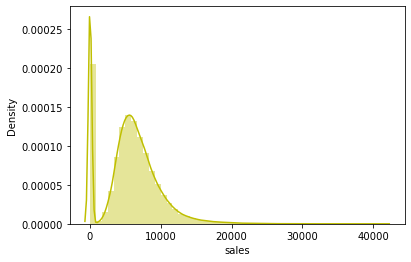

In [19]:
sns.distplot(df1['sales'],color='y')

## 1.7.2. Categorical Attributes

In [20]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday                    5
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

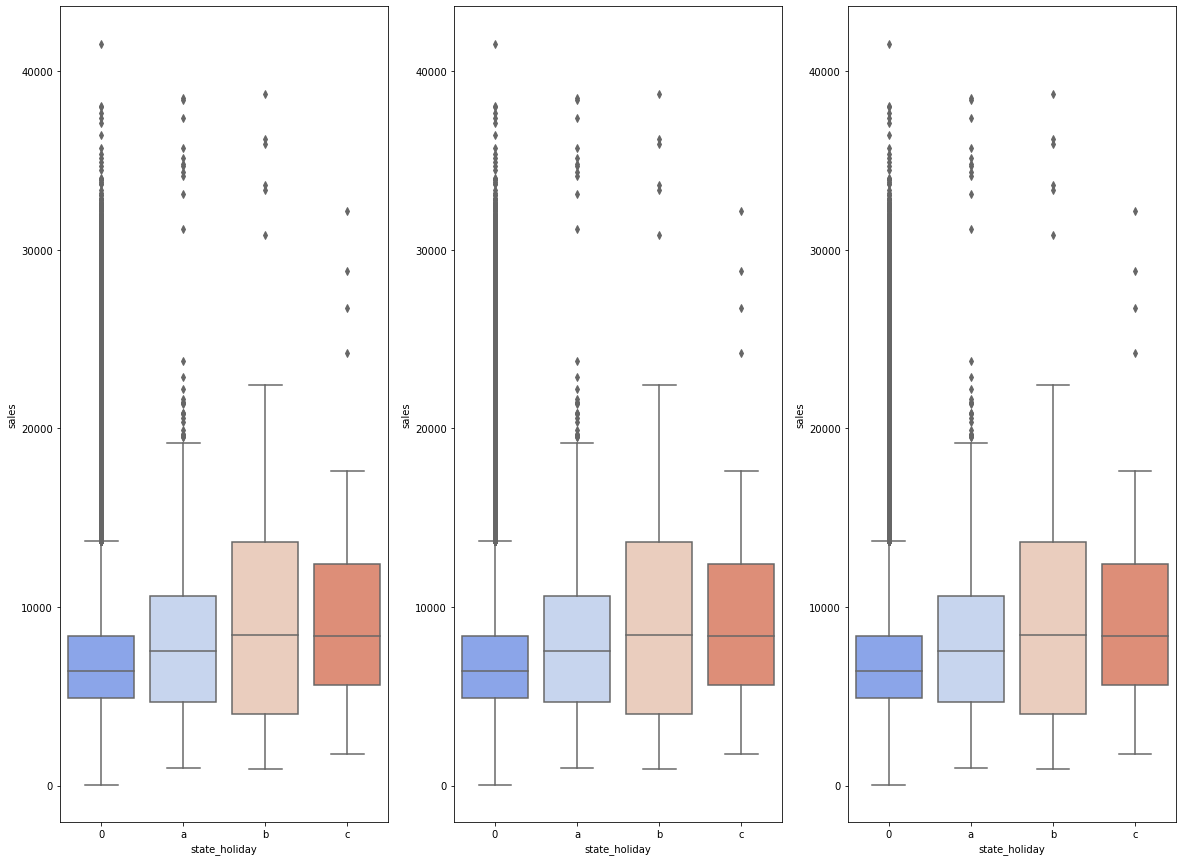

In [21]:
fig, aux1 = plt.subplots(figsize=(20,15))
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm')

plt.subplot(1, 3, 2)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

plt.subplot(1, 3, 3)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

In [22]:
df2 = df1.copy()

In [23]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# transform 'float' to 'int' because of error
# df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
# df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],  month=x['competition_open_since_month'], day= 1), axis=1) 
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply ( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype ( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a'else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 2.0. STEP 2 - FEATURE ENGINEERING

## 2.1. Hypothesis Mindmap

## 2.2. Creating Hypothesis

### 2.1.1 -  Store Hypothesis

**1.** Stores with more employers should sell more.

**2.** Stores with higher stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with more options should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for longer should sell less. 


### 2.1.2 -  Products Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that expose more their products should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have agressive discounts should sell more.

**5.** Stores that have promotions for longer should sell more.

**6.** Stores with higher number of active promo days sell more.

**7.** Stores with more consecutive promo days sell more.

### 2.1.3 -   Temporal Hypothesis

**1.** Stores that open on Christmas should sell more. 

**2.** Stores should sell more when around for longer.

**3.** Stores should sell more on the second semester.

**4.** Stores should sell more after the 10th.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays. 

## 2.3. Final Hypothesis

**1.**  Stores with more options should sell more.

**2.**  Stores with closer competitors should sell less.

**3.**  Stores with competitors for longer should sell more.

**4.**  Stores that have promotions for longer should sell more.

**5.**  Stores with higher number of active promo days sell more.

**6.**  Stores with more consecutive promo days sell more.

**7.**  Stores with more consecutive promo days sell more.

**8.**  Stores that open on Christmas should sell more.

**9.**  Stores should sell more when around for longer.

**10.** Stores should sell more on the second semester.

**11.** Stores should sell more after the 10th.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

In [24]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1. Univariable Anaysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

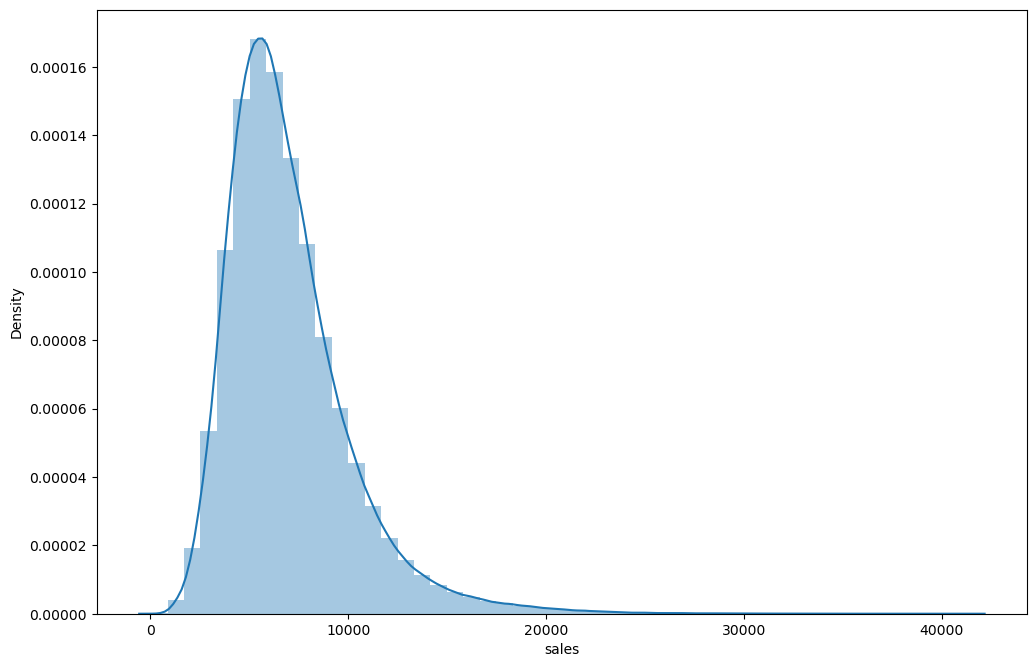

In [31]:
fig, ax = plt.subplots(figsize=(12,8),dpi=100);
sns.distplot(df4['sales'] )

### 4.1.2. Numerical Variable

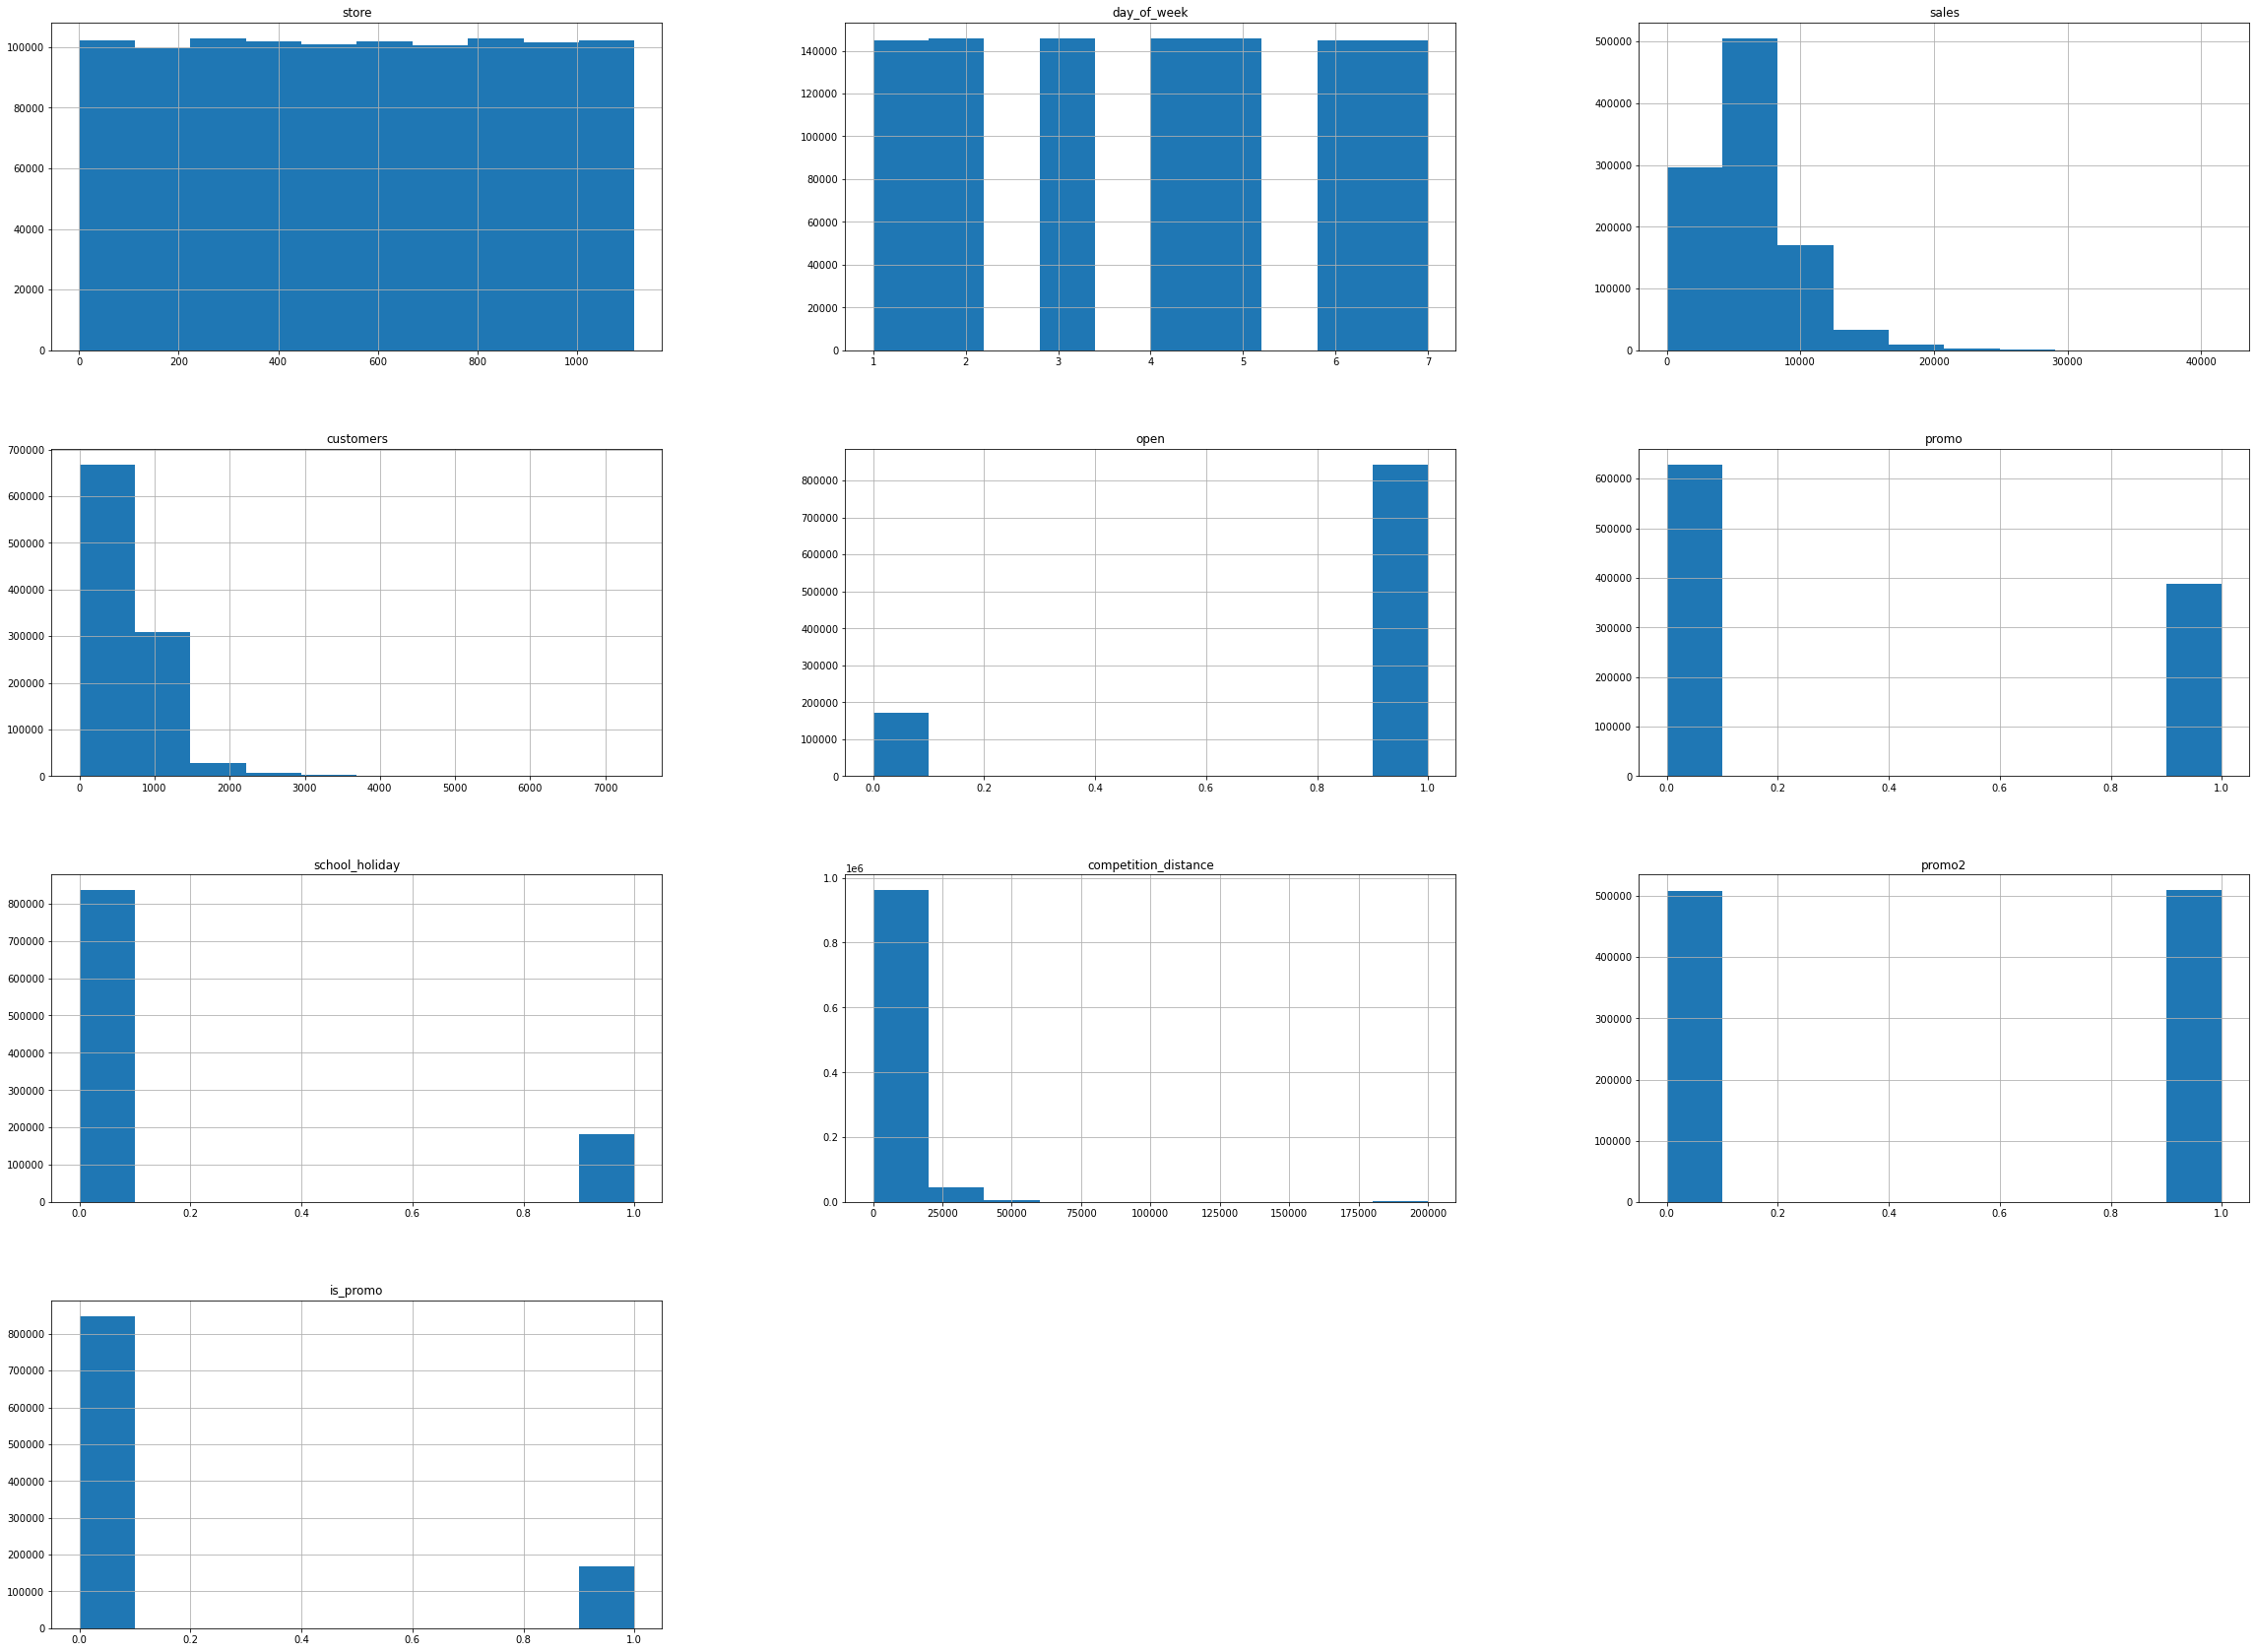

In [33]:
 fig = num_att.hist(figsize=(40,30))

In [34]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

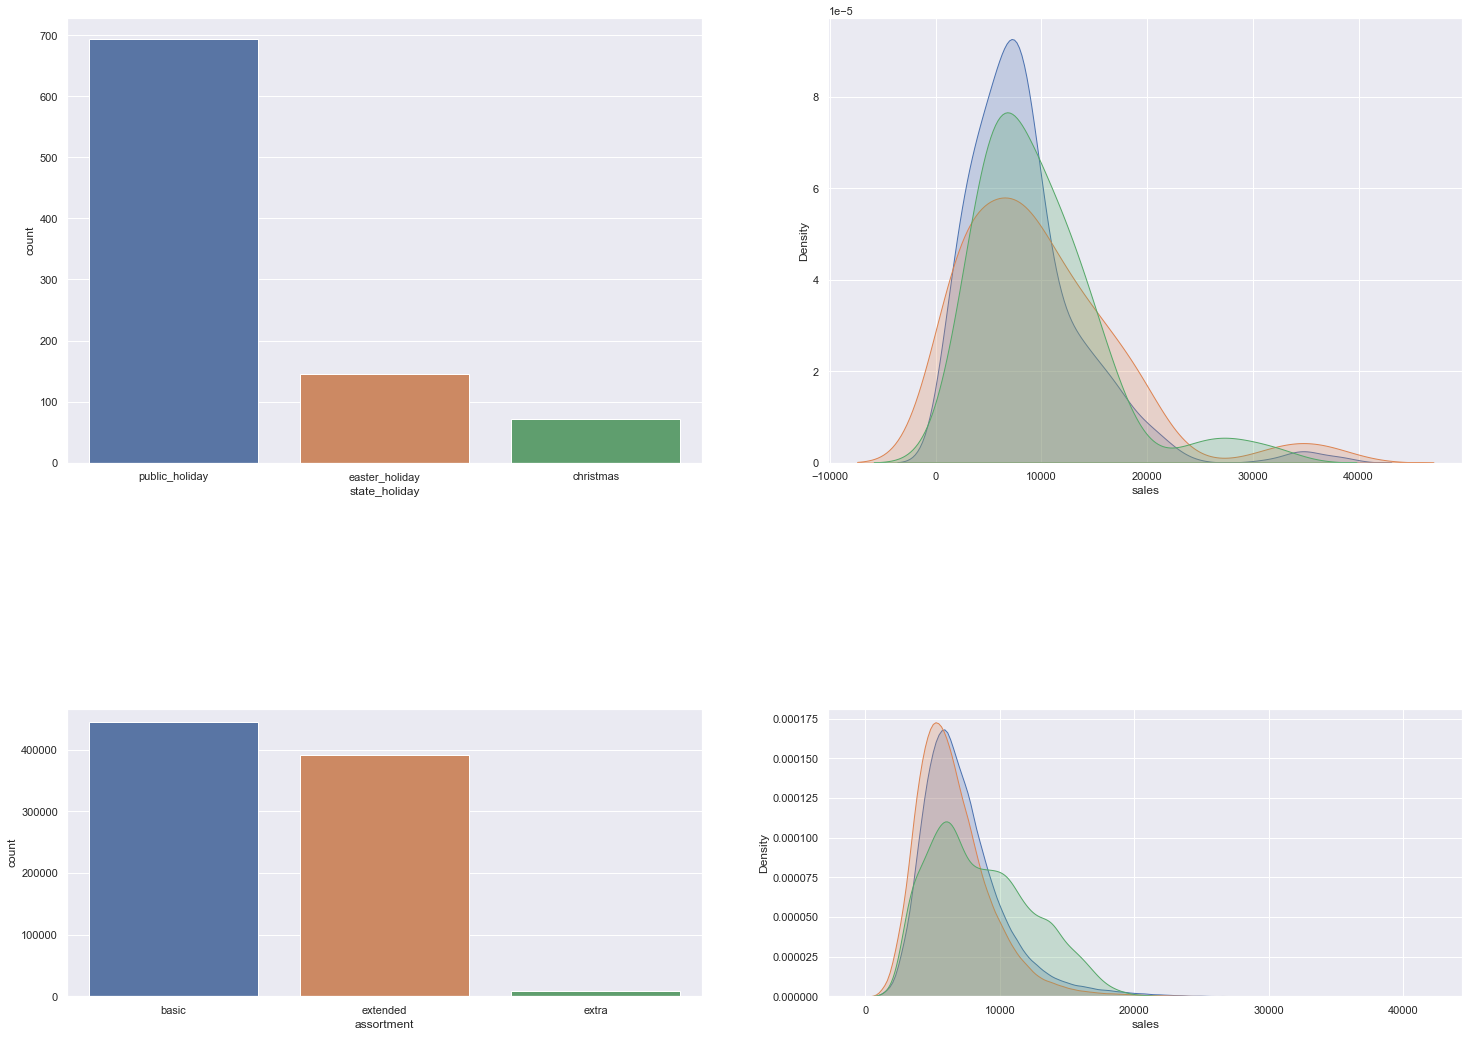

In [37]:
sns.set_theme()                                           
plt.rcParams['figure.figsize'] = [25, 18]                         
# state_holiday
plt.subplot(2, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(2, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday',shade=True,)

# store_type
plt.subplot(2, 2, 3 )

sns.countplot( df4['store_type'] )

plt.subplot(2, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True,)

# assortment
plt.subplot(3, 2, 5 )

sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True,)

## 4.2. Bivariable Anaysis

### H1. Stores with more options should sell more.
**FALSE.** Stores with more options sell less.

<AxesSubplot:xlabel='year_week'>

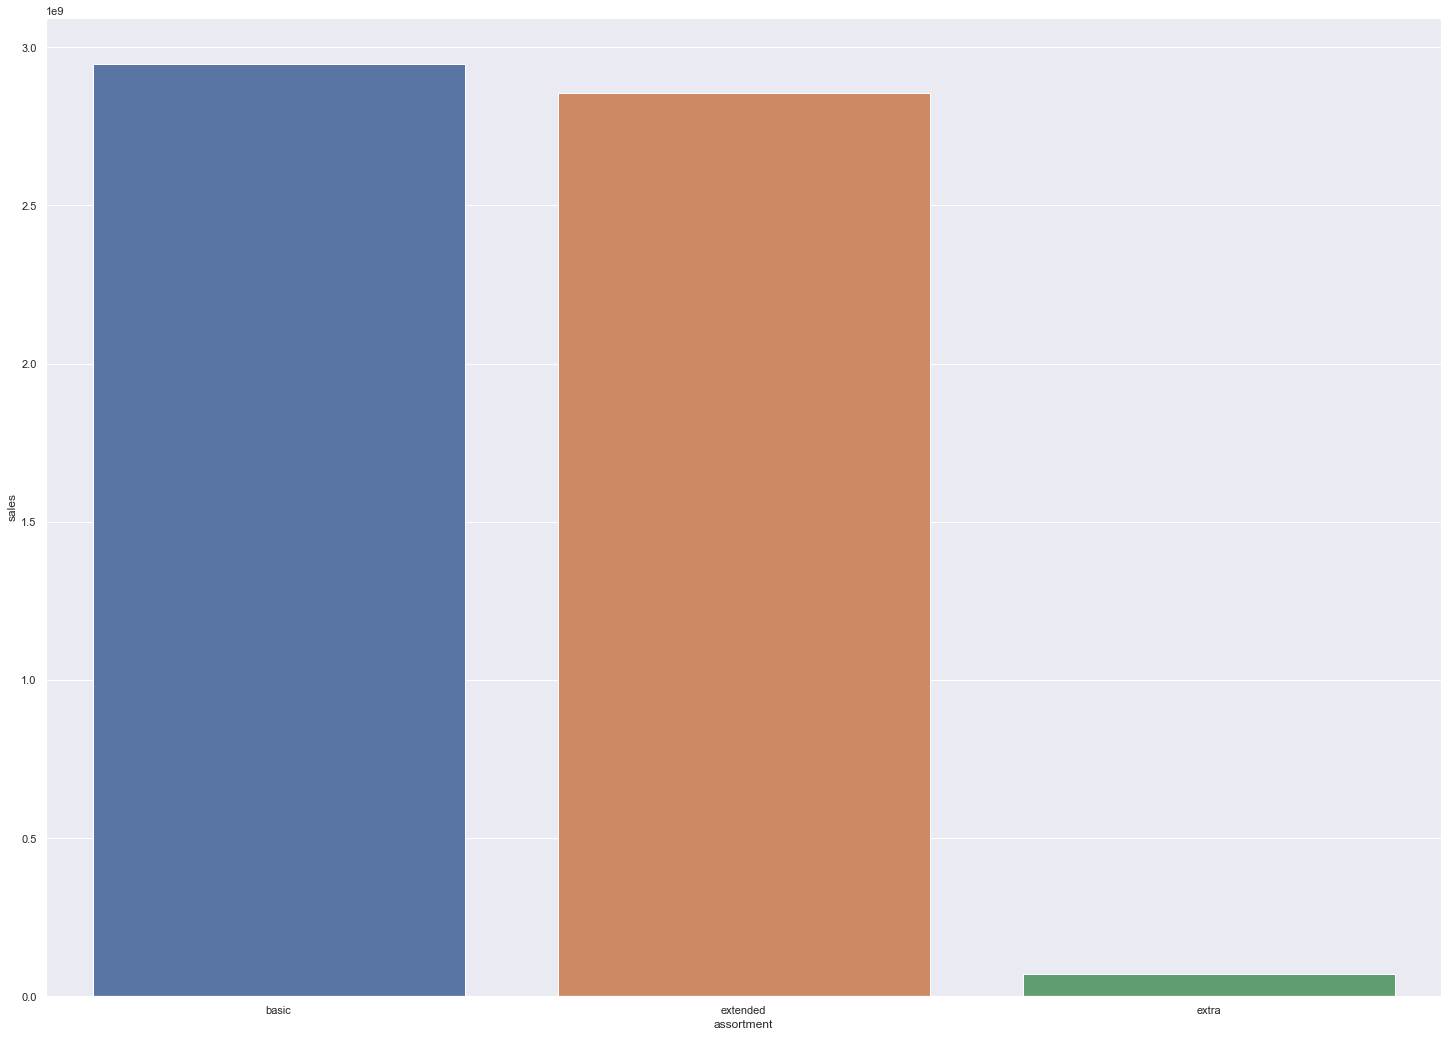

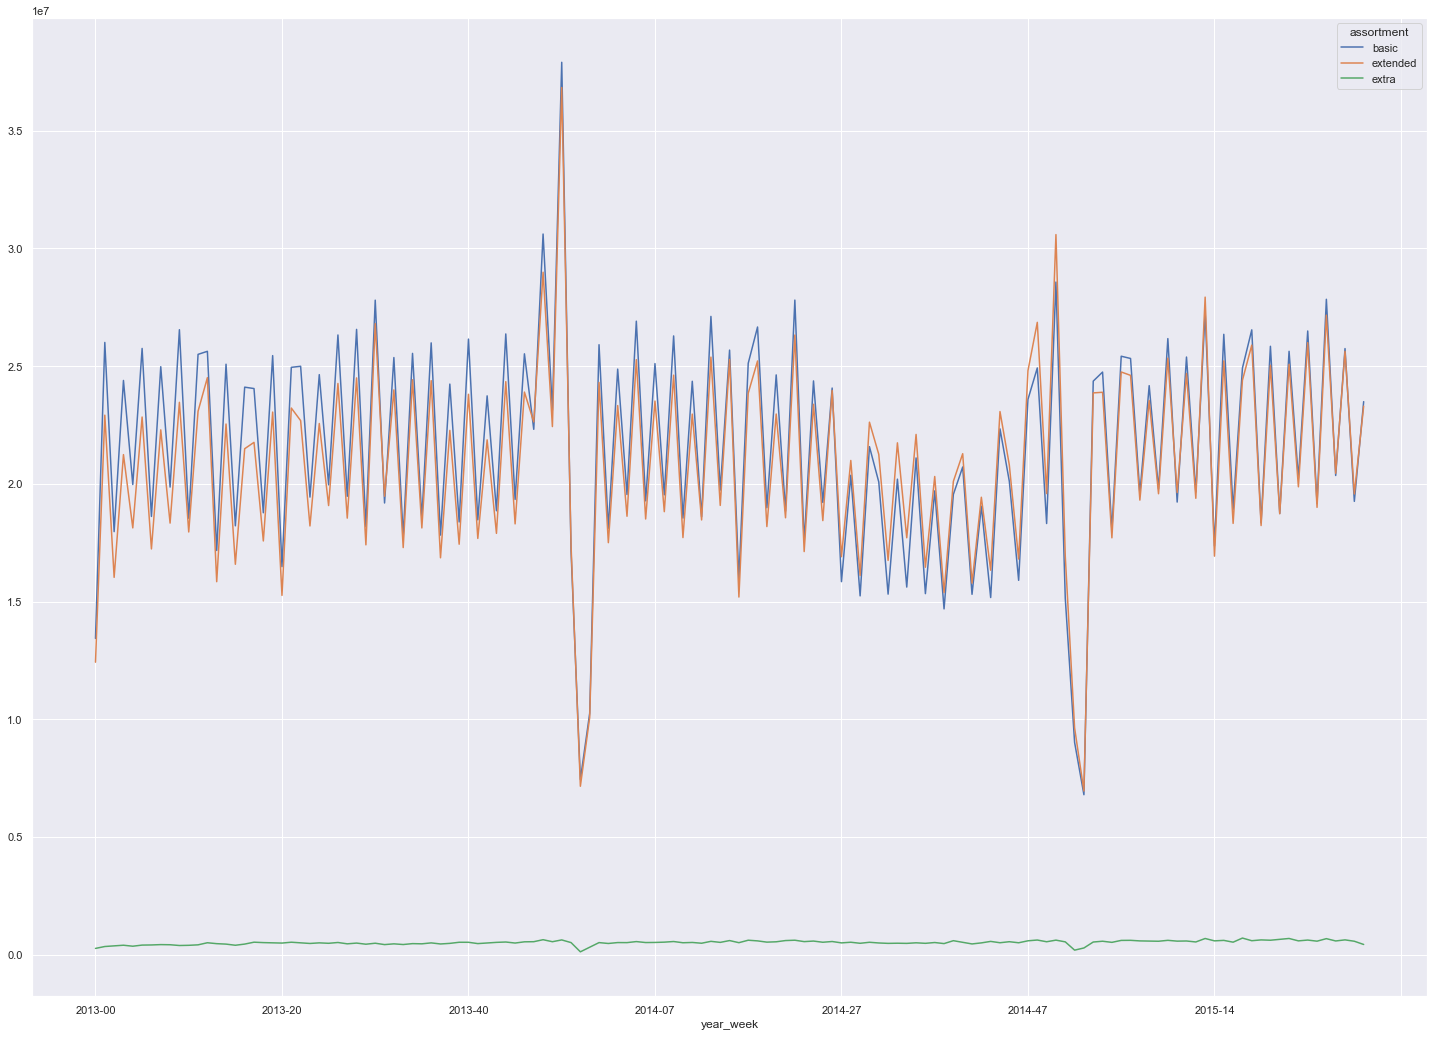

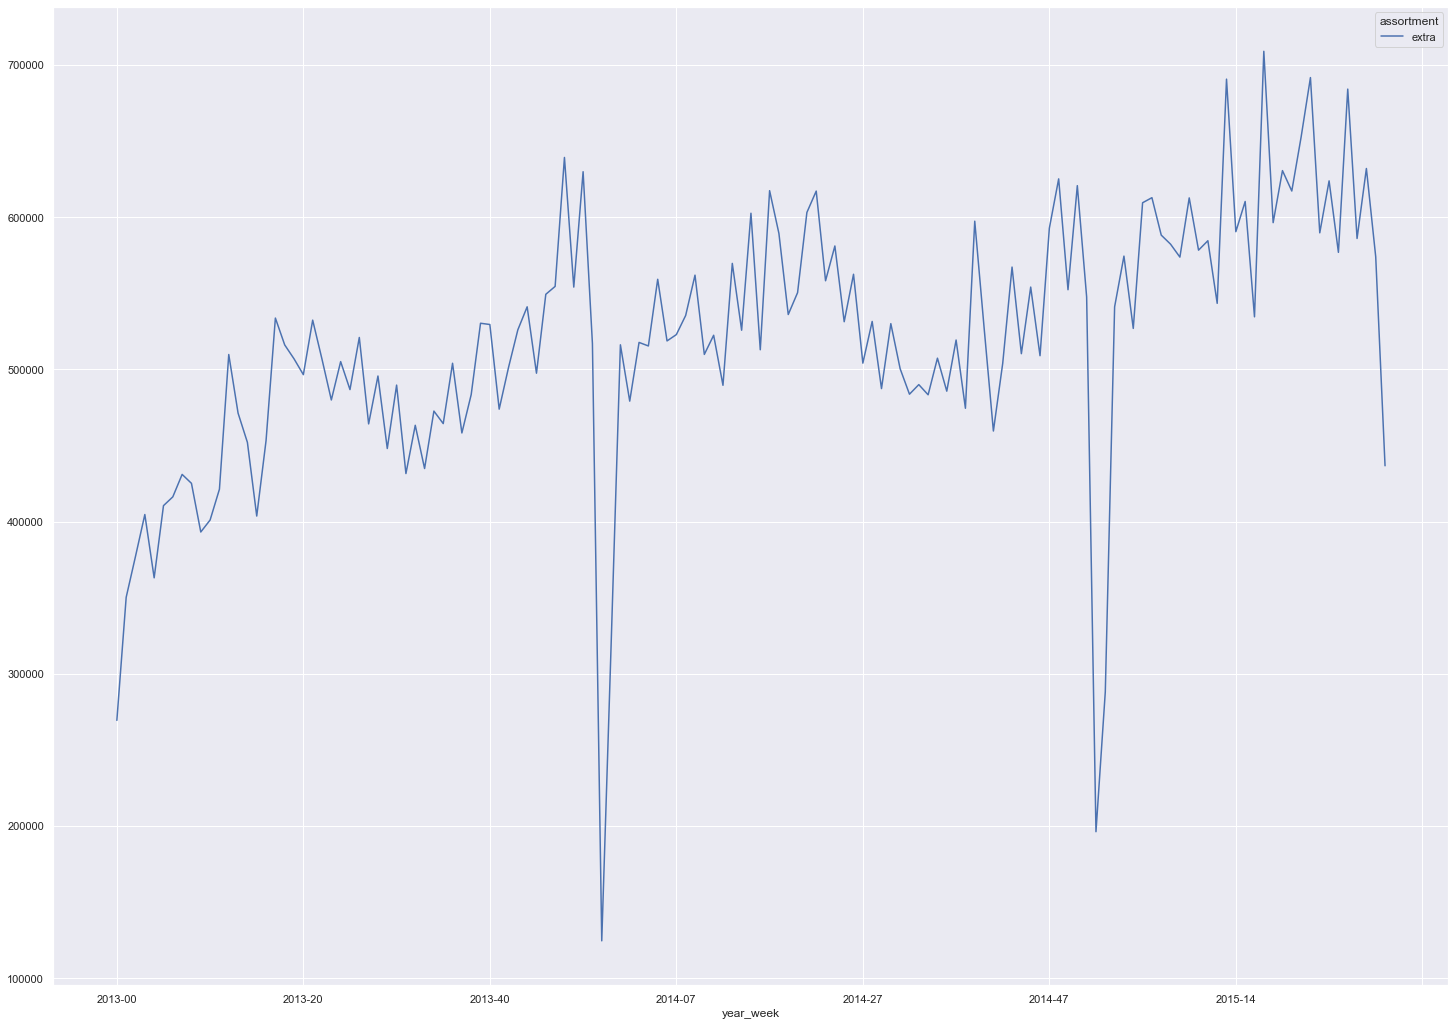

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

### H2. Stores with closer competitors should sell less.
**FALSE**. Stores with closer competitors sell more.

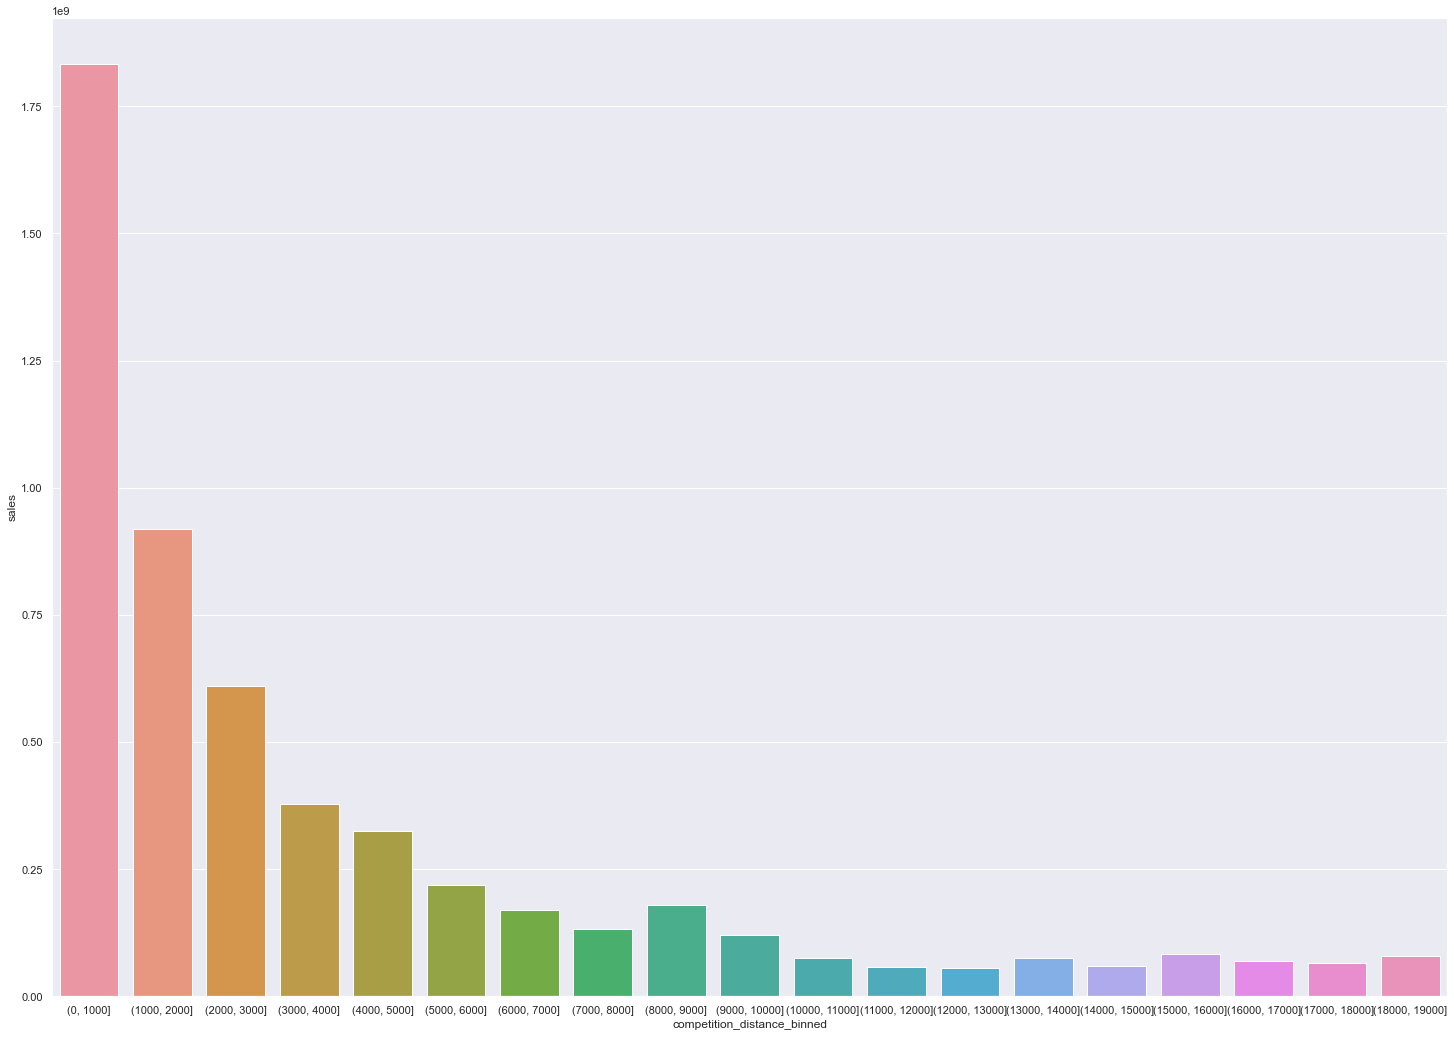

In [48]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0,  20000, 1000) )

aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);
 

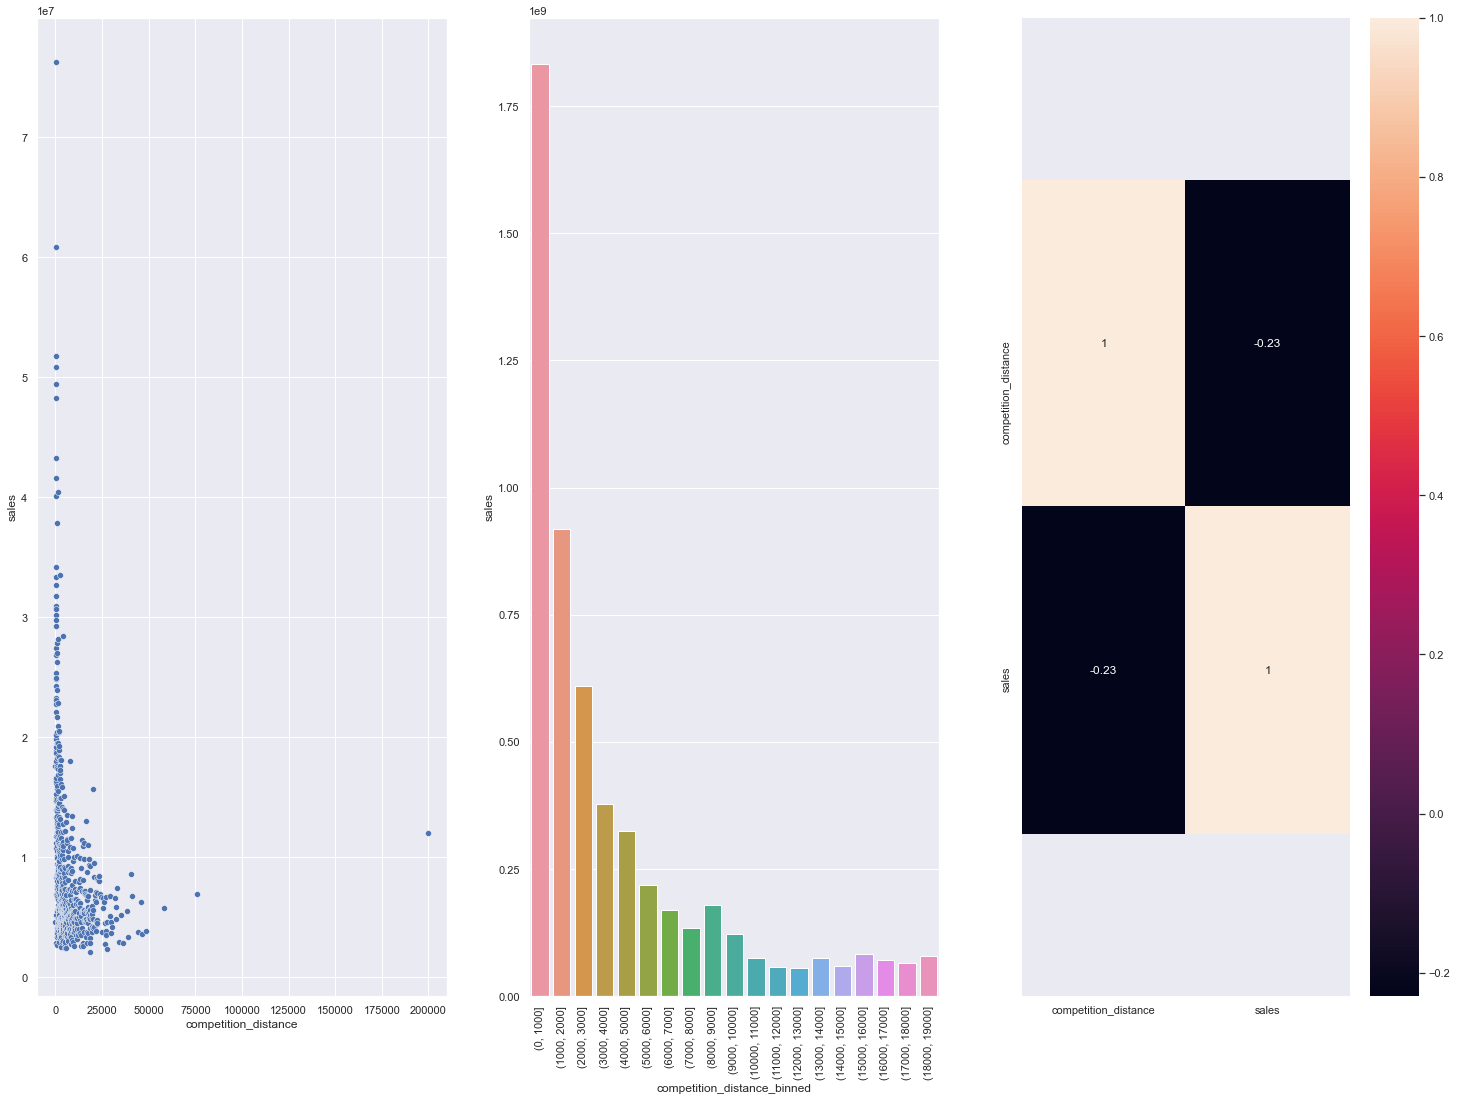

In [57]:
# measuring the corelation between the distance and the voume of sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x='competition_distance',y='sales', data=aux1 );

plt.subplot(1, 3, 2 )
bins = list( np.arange( 0,  20000, 1000) )
aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);

# rotate axis for better visualization
plt.xticks( rotation= 90);


plt.subplot( 1, 3, 3)
x= sns.heatmap( aux1.corr( method='pearson' ), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## 3. Stores with competitors for longer should sell more.
**FALSE**. Stores with competitors for longer sell less.

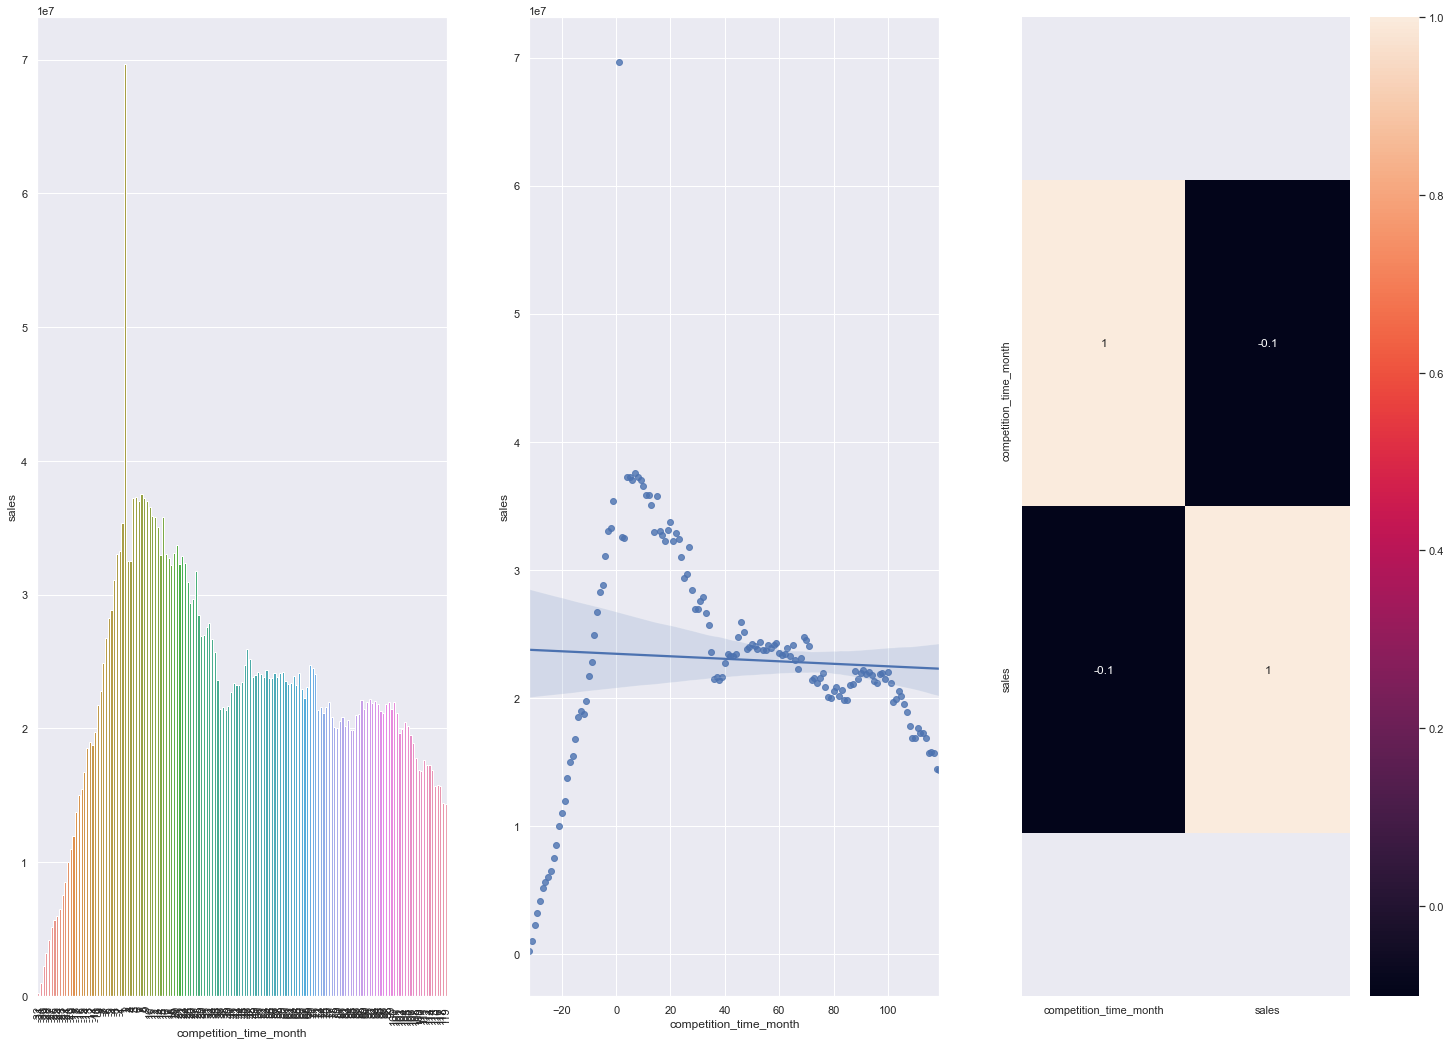

In [67]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month']  != 0)]
sns.barplot(x= 'competition_time_month',y='sales',data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## 4.3. Multivariable Anaysis

# 5.0.

# 6.0.

# 7.0.

# 8.0.

# 1.0.